# Classification sample on Rotten Tomatoes movie reviews

In [256]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

# this allows plots to appear directly in the notebook
%matplotlib inline

# prettify charts
plt.style.use('ggplot')

## Import data
Data set taken from [Kaggle: Movie Reviews](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews).

Some examples:

  * 4 (positive): "They works spectacularly well... A shiver-inducing, nerve-rattling ride."
  * 3 (somewhat positive): "rooted in a sincere performance by the title character undergoing midlife crisis"
  * 2 (neutral): "Its everything you would expect -- but nothing more."
  * 1 (somewhat negative): "But it does not leave you with much."
  * 0 (negative): "The movies progression into rambling incoherence gives new meaning to the phrase fatal script error."

In [ ]:
phrases = pd.read_csv('d:/docs/ml/datas/movies/train.tsv', sep = '\t', index_col = 0)

## Inspect data

### Original data

In [ ]:
phrases.head()

### What do the sentences look like?

In [ ]:
# print the first sentence
phrases.iloc[0]['Phrase']

In [ ]:
phrases.loc[lambda row: row.SentenceId == 2].iloc[0]['Phrase']
#df.loc[lambda row: row.SentenceId == 2]

## Okay, let's go

### Count words

In [239]:
small = phrases[phrases['SentenceId'] < 100]
#phrases['WordsCount'] = phrases['Phrase'].str.split().sum(axis = 0) #.apply(lambda phrase: pd.value_counts(phrase.split()))
# phrases['WordsCount'] = phrases['Phrase'].apply(lambda phrase: pd.value_counts(phrase.split()))

In [ ]:
small.shape
#small.head()
#len(small.iloc[0]['Phrase'].split())

In [ ]:
import re
re.findall('\w+', " a,   bee and don't see.")

In [240]:
small['WordsCount'] = small.apply(lambda row: len(re.findall('\w+', row['Phrase'])), axis = 1)
# small['WordsCount'] = small.apply(lambda row: len(row['Phrase'].split()), axis = 1)

C:\Users\ibarcan\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Build collections of positive & negative words, respectively

In [241]:
positives = small[(small['WordsCount'] <= 3) & (small['Sentiment'] >= 3)]
# positives = small[small['Sentiment'] == 4]
# positives.drop_duplicates(subset = 'Phrase')
positives.head()
positives.shape

(241, 4)

In [242]:
negatives = small[(small['WordsCount'] <= 3) & (small['Sentiment'] <= 1)]
# negatives.drop_duplicates(subset = 'Phrase')
# negatives.head()
negatives.shape
# negatives

(174, 4)

### For each phrase, count the positives and the negatives within...

That's gonna take a while... :-<

In [244]:
posphrases = positives['Phrase'].values

In [245]:
negphrases = negatives['Phrase'].values

In [246]:
def count_occurences(phrase, sublist):
    counter = 0
    for sub in sublist:
        counter += phrase.count(sub)
    return counter

In [247]:
count_occurences("thrilling and high hilarity", posphrases)

4

In [248]:
small['PositivesCount'] = small.apply(
    lambda row: count_occurences(row['Phrase'], posphrases), axis = 1)

small['NegativesCount'] = small.apply(
    lambda row: count_occurences(row['Phrase'], negphrases), axis = 1)

C:\Users\ibarcan\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\ibarcan\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
small.head()

### Now let's draw something...

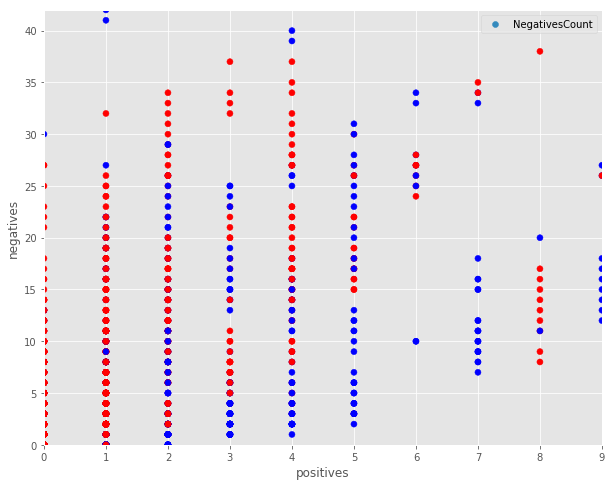

In [249]:
# setup figure
plt.figure(figsize=(10, 8))

# scatter plot of positive phrases (x) and negative phrases (y)
ax1=plt.subplot(111)
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax1.scatter(small.PositivesCount, small.NegativesCount, c = (small.Sentiment >= 3), cmap = cm_bright)
ax1.set_xlim((small.PositivesCount.min(), small.PositivesCount.max()))
ax1.set_ylim((small.NegativesCount.min(), small.NegativesCount.max()))
ax1.set_xlabel('positives')
ax1.set_ylabel('negatives')
ax1.legend(loc = 'upper right')

In [ ]:
from sklearn.linear_model import LinearRegression

# get feature/predictor matrix as numpy array
X = small[['PositivesCount', 'NegativesCount']].values

# encode class labels
classes, y = np.unique(small.Sentiment.values, return_inverse = True)
newy = []
for v in y:
    if v < 3:
        newy.append(-1)
    else:
        newy.append(1)
# map {0, 1, 2, 3, 4} to {-1, 1}

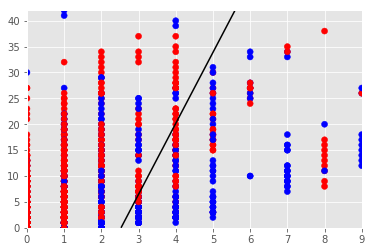

In [268]:
# fit OLS regression 
est = LinearRegression(fit_intercept=True, normalize=True)
est.fit(X, newy)

# plot data and decision surface
ax = plt.gca()
ax.scatter(small.PositivesCount, small.NegativesCount, c = (small.Sentiment >= 3), cmap = cm_bright)
try:
    plot_surface(est, X[:, 0], X[:, 1], ax=ax)
except NameError:
    print('Please run cells in Appendix first')

Appendix:

In [267]:
# utility function to plot the decision surface
def plot_surface(est, x_1, x_2, ax=None, threshold=0.0, contourf=False):
    """Plots the decision surface of ``est`` on features ``x1`` and ``x2``. """
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))
    # plot the hyperplane by evaluating the parameters on the grid
    X_pred = np.c_[xx1.ravel(), xx2.ravel()]  # convert 2d grid into seq of points
    if hasattr(est, 'predict_proba'):  # check if ``est`` supports probabilities
        # take probability of positive class
        pred = est.predict_proba(X_pred)[:, 1]
    else:
        pred = est.predict(X_pred)
    Z = pred.reshape((100, 100))  # reshape seq to grid
    if ax is None:
        ax = plt.gca()
    # plot line via contour plot

    if contourf:
        ax.contourf(xx1, xx2, Z, levels=np.linspace(0, 1.0, 10), cmap=plt.cm.RdBu, alpha=0.6)
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

def plot_datasets(est=None):
    """Plotsthe decision surface of ``est`` on each of the three datasets. """
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
    for (name, ds), ax in zip(datasets.iteritems(), axes):
        X_train = ds['X_train']
        y_train = ds['y_train']
        X_test = ds['X_test']
        y_test = ds['y_test']

        # plot test lighter than training
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])
        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
        # plot limits
        ax.set_xlim(X_train[:, 0].min(), X_train[:, 0].max())
        ax.set_ylim(X_train[:, 1].min(), X_train[:, 1].max())
        # no ticks
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_ylabel('$x_1$')
        ax.set_xlabel('$x_0$')
        ax.set_title(name)
        if est is not None:
            est.fit(X_train, y_train)
            plot_surface(est, X_train[:, 0], X_train[:, 1], ax=ax, threshold=0.5, contourf=True)
            err = (y_test != est.predict(X_test)).mean()
            ax.text(0.88, 0.02, '%.2f' % err, transform=ax.transAxes)

    fig.subplots_adjust(left=.02, right=.98)